# Windy Gridworld problem
Exercise 6.9 of the book

In [33]:
from abc import ABCMeta, abstractmethod
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt

In [34]:
class BaseEnvironment:
    """Implements the environment for an RLGlue environment

    Note:
        env_init, env_start, env_step, env_cleanup, and env_message are required
        methods.
    """

    __metaclass__ = ABCMeta

    def __init__(self):
        reward = None
        observation = None
        termination = None
        self.reward_obs_term = (reward, observation, termination)

    @abstractmethod
    def env_init(self, env_info={}):
        """Setup for the environment called when the experiment first starts.

        Note:
            Initialize a tuple with the reward, first state observation, boolean
            indicating if it's terminal.
        """

    @abstractmethod
    def env_start(self):
        """The first method called when the experiment starts, called before the
        agent starts.

        Returns:
            The first state observation from the environment.
        """

    @abstractmethod
    def env_step(self, action):
        """A step taken by the environment.

        Args:
            action: The action taken by the agent

        Returns:
            (float, state, Boolean): a tuple of the reward, state observation,
                and boolean indicating if it's terminal.
        """

    @abstractmethod
    def env_cleanup(self):
        """Cleanup done after the environment ends"""

    @abstractmethod
    def env_message(self, message):
        """A message asking the environment for information

        Args:
            message: the message passed to the environment

        Returns:
            the response (or answer) to the message
        """


In [35]:
class BaseAgent:
    """Implements the agent for an RL-Glue environment.
    Note:
        agent_init, agent_start, agent_step, agent_end, agent_cleanup, and
        agent_message are required methods.
    """

    __metaclass__ = ABCMeta

    def __init__(self):
        pass

    @abstractmethod
    def agent_init(self, agent_info= {}):
        """Setup for the agent called when the experiment first starts."""

    @abstractmethod
    def agent_start(self, observation):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            observation (Numpy array): the state observation from the environment's evn_start function.
        Returns:
            The first action the agent takes.
        """

    @abstractmethod
    def agent_step(self, reward, observation):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            observation (Numpy array): the state observation from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """

    @abstractmethod
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the terminal state.
        """

    @abstractmethod
    def agent_cleanup(self):
        """Cleanup done after the agent ends."""

    @abstractmethod
    def agent_message(self, message):
        """A function used to pass information from the agent to the experiment.
        Args:
            message: The message passed to the agent.
        Returns:
            The response (or answer) to the message.
        """

In [43]:
class Environment(BaseEnvironment):
    """Implements the environment for an RLGlue environment

    Note:
        env_init, env_start, env_step, env_cleanup, and env_message are required
        methods.
    """

    def env_init(self, env_info={}):
        """Setup for the environment called when the experiment first starts.

        Note:
            Initialize a tuple with the reward, first state observation, boolean
            indicating if it's terminal.
        """
        self.rows = 7
        self.cols = 10
        self.start = [3,0]
        self.goal = [3,7]
        self.current_state = None

    def env_start(self):
        """The first method called when the episode starts, called before the
        agent starts.

        Returns:
            The first state observation from the environment.
        """
        self.current_state = self.start  # An empty NumPy array

        self.reward_obs_term = (0.0, self.observation(self.current_state), False)

        return self.reward_obs_term[1]

    def env_step(self, action):
        """A step taken by the environment.

        Args:
            action: The action taken by the agent

        Returns:
            (float, state, Boolean): a tuple of the reward, state observation,
                and boolean indicating if it's terminal.
        """

        new_state = deepcopy(self.current_state)
        # 5 6 7
        # 4   0
        # 3 2 1
        mod = 0
        if new_state[1] in [3,4,5,8]:
            mod = 1
        elif new_state[1] in [6,7]:
            mod = 2
        
        if action == 0: # right
            new_state[1] += 1
        elif action == 2: #down
            new_state[0] -= 1
        elif action == 4: #left
            new_state[1] -= 1
        elif action == 6: #up
            new_state[0] += 1
        elif action == 1: # down-right
            new_state[0] -= 1
            new_state[1] += 1
        elif action == 3: # down-left
            new_state[0] -= 1
            new_state[1] -= 1
        elif action == 5: # up-left
            new_state[0] += 1
            new_state[1] -= 1
        elif action == 7: # up right
            new_state[0] += 1
            new_state[1] += 1
        else:
            raise Exception("Invalid action.")
        self.current_state = new_state
        
        new_state[0] += mod

        new_state[0] = np.clip(new_state[0], 0, self.rows-1)
        new_state[1] = np.clip(new_state[1], 0, self.cols-1)
        
        reward = -1.0
        
        is_terminal = new_state == self.goal
        
        self.reward_obs_term = (reward, self.observation(self.current_state), is_terminal)

        return self.reward_obs_term

    def observation(self, state):
        return state[0] * self.cols + state[1] 

    def env_cleanup(self):
        """Cleanup done after the environment ends"""
        pass

    def env_message(self, message):
        """A message asking the environment for information

        Args:
            message (string): the message passed to the environment

        Returns:
            string: the response (or answer) to the message
        """
        if message == "what is the current reward?":
            return "{}".format(self.reward_obs_term[0])

        # else
        return "I don't know how to respond to your message"


In [73]:
class ExpectedSarsaAgent(BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_info["seed"])
        
        # Create an array for action-value estimates and initialize it to zero.
        self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.

        
    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state,:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        # Perform an update 
        num_greedy = np.count_nonzero(current_q == np.max(current_q))
        prob = np.ones(self.num_actions) * self.epsilon / self.num_actions
        prob[current_q == np.max(current_q)] += (1 - self.epsilon) / num_greedy
        expected = np.sum(prob * current_q)

        self.q[self.prev_state, self.prev_action] = self.q[self.prev_state, self.prev_action] + \
            self.step_size * (reward + self.discount * expected - self.q[self.prev_state, self.prev_action])
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode
        self.q[self.prev_state, self.prev_action] = self.q[self.prev_state, self.prev_action] + \
            self.step_size * (reward - self.q[self.prev_state, self.prev_action])
        
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)
    
    def agent_message(self, message):
        if message == 'Q':
            return self.q

In [74]:
class QLearningAgent(BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_info["seed"])
        
        # Create an array for action-value estimates and initialize it to zero.
        self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.

        
    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state,:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        # Perform an update (1 line)
        ### START CODE HERE ###
        self.q[self.prev_state, self.prev_action] = self.q[self.prev_state, self.prev_action] + \
            self.step_size * (reward + self.discount * np.max(self.q[state, :]) - self.q[self.prev_state, self.prev_action])
        ### END CODE HERE ###
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode (1 line)
        ### START CODE HERE ###
        self.q[self.prev_state, self.prev_action] = self.q[self.prev_state, self.prev_action] + \
            self.step_size * (reward - self.q[self.prev_state, self.prev_action])
        ### END CODE HERE ###
        
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)
    
    def agent_message(self, message):
        if message == 'Q':
            return self.q

In [75]:
class RLGlue:
    """RLGlue class

    args:
        env_name (string): the name of the module where the Environment class can be found
        agent_name (string): the name of the module where the Agent class can be found
    """

    def __init__(self, env_class, agent_class):
        self.environment = env_class()
        self.agent = agent_class()

        self.total_reward = None
        self.last_action = None
        self.num_steps = None
        self.num_episodes = None

    def rl_init(self, agent_init_info={}, env_init_info={}):
        """Initial method called when RLGlue experiment is created"""
        self.environment.env_init(env_init_info)
        self.agent.agent_init(agent_init_info)

        self.total_reward = 0.0
        self.num_steps = 0
        self.num_episodes = 0

    def rl_start(self, agent_start_info={}, env_start_info={}):
        """Starts RLGlue experiment

        Returns:
            tuple: (state, action)
        """
        
        self.total_reward = 0.0
        self.num_steps = 1

        last_state = self.environment.env_start()
        self.last_action = self.agent.agent_start(last_state)

        observation = (last_state, self.last_action)

        return observation

    def rl_agent_start(self, observation):
        """Starts the agent.

        Args:
            observation: The first observation from the environment

        Returns:
            The action taken by the agent.
        """
        return self.agent.agent_start(observation)

    def rl_agent_step(self, reward, observation):
        """Step taken by the agent

        Args:
            reward (float): the last reward the agent received for taking the
                last action.
            observation : the state observation the agent receives from the
                environment.

        Returns:
            The action taken by the agent.
        """
        return self.agent.agent_step(reward, observation)

    def rl_agent_end(self, reward):
        """Run when the agent terminates

        Args:
            reward (float): the reward the agent received when terminating
        """
        self.agent.agent_end(reward)

    def rl_env_start(self):
        """Starts RL-Glue environment.

        Returns:
            (float, state, Boolean): reward, state observation, boolean
                indicating termination
        """
        self.total_reward = 0.0
        self.num_steps = 1

        this_observation = self.environment.env_start()

        return this_observation

    def rl_env_step(self, action):
        """Step taken by the environment based on action from agent

        Args:
            action: Action taken by agent.

        Returns:
            (float, state, Boolean): reward, state observation, boolean
                indicating termination.
        """
        ro = self.environment.env_step(action)
        (this_reward, _, terminal) = ro

        self.total_reward += this_reward

        if terminal:
            self.num_episodes += 1
        else:
            self.num_steps += 1

        return ro

    def rl_step(self):
        """Step taken by RLGlue, takes environment step and either step or
            end by agent.

        Returns:
            (float, state, action, Boolean): reward, last state observation,
                last action, boolean indicating termination
        """

        (reward, last_state, term) = self.environment.env_step(self.last_action)

        self.total_reward += reward;

        if term:
            self.num_episodes += 1
            self.agent.agent_end(reward)
            roat = (reward, last_state, None, term)
        else:
            self.num_steps += 1
            self.last_action = self.agent.agent_step(reward, last_state)
            roat = (reward, last_state, self.last_action, term)

        return roat

    def rl_cleanup(self):
        """Cleanup done at end of experiment."""
        self.environment.env_cleanup()
        self.agent.agent_cleanup()

    def rl_agent_message(self, message):
        """Message passed to communicate with agent during experiment

        Args:
            message: the message (or question) to send to the agent

        Returns:
            The message back (or answer) from the agent

        """

        return self.agent.agent_message(message)

    def rl_env_message(self, message):
        """Message passed to communicate with environment during experiment

        Args:
            message: the message (or question) to send to the environment

        Returns:
            The message back (or answer) from the environment

        """
        return self.environment.env_message(message)

    def rl_episode(self, max_steps_this_episode):
        """Runs an RLGlue episode

        Args:
            max_steps_this_episode (Int): the maximum steps for the experiment to run in an episode

        Returns:
            Boolean: if the episode should terminate
        """
        is_terminal = False

        self.rl_start()

        while (not is_terminal) and ((max_steps_this_episode == 0) or
                                     (self.num_steps < max_steps_this_episode)):
            rl_step_result = self.rl_step()
            is_terminal = rl_step_result[3]

        return is_terminal

    def rl_return(self):
        """The total reward

        Returns:
            float: the total reward
        """
        return self.total_reward

    def rl_num_steps(self):
        """The total number of steps taken

        Returns:
            Int: the total number of steps taken
        """
        return self.num_steps

    def rl_num_episodes(self):
        """The number of episodes

        Returns
            Int: the total number of episodes

        """
        return self.num_episodes


In [76]:
agents = {
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}
env = Environment
all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
agent_info = {"num_actions": 8, "num_states": 70, "epsilon": 0.1, "step_size": 0.5, "discount": 1.0}
env_info = {}
num_runs = 100 # The number of runs
num_episodes = 500 # The number of episodes in each run

for algorithm in ["Q-learning", "Expected Sarsa"]:
    all_reward_sums[algorithm] = []
    all_state_visits[algorithm] = []
    for run in tqdm(range(num_runs)):
        agent_info["seed"] = run
        rl_glue = RLGlue(env, agents[algorithm])
        rl_glue.rl_init(agent_info, env_info)

        reward_sums = []
        state_visits = np.zeros(70)
        for episode in range(num_episodes):
            if episode < num_episodes - 10:
                # Runs an episode
                rl_glue.rl_episode(0) 
            else: 
                # Runs an episode while keeping track of visited states
                state, action = rl_glue.rl_start()
                state_visits[state] += 1
                is_terminal = False
                while not is_terminal:
                    reward, state, action, is_terminal = rl_glue.rl_step()
                    state_visits[state] += 1
                
            reward_sums.append(rl_glue.rl_return())
            
        all_reward_sums[algorithm].append(reward_sums)
        all_state_visits[algorithm].append(state_visits)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.16it/s]


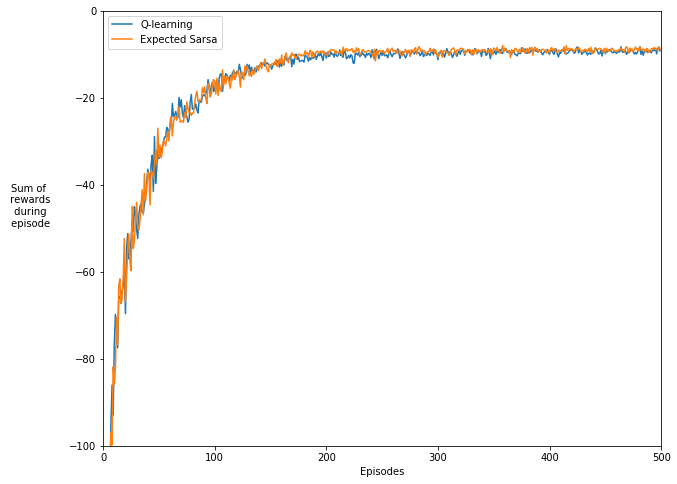

In [77]:
plt.figure(figsize=(10,8))
for algorithm in ["Q-learning", "Expected Sarsa"]:
    plt.plot(np.mean(all_reward_sums[algorithm], axis=0), label=algorithm)
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.xlim(0,500)
plt.ylim(-100,0)
plt.legend()
plt.show()

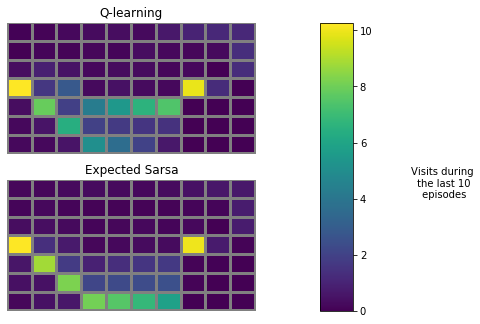

In [78]:
for algorithm, position in [("Q-learning", 211), ("Expected Sarsa", 212)]:
    plt.subplot(position)
    average_state_visits = np.array(all_state_visits[algorithm]).mean(axis=0)
    grid_state_visits = average_state_visits.reshape((7, 10))
    plt.pcolormesh(grid_state_visits, edgecolors='gray', linewidth=2)
    plt.title(algorithm)
    plt.axis('off')
    cm = plt.get_cmap()
    cm.set_bad('gray')

    plt.subplots_adjust(bottom=0.0, right=0.7, top=1.0)
cax = plt.axes([0.85, 0.0, 0.075, 1.])
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel("Visits during\n the last 10\n episodes", rotation=0, labelpad=70)
plt.show()

In [80]:
q = rl_glue.agent.agent_message('Q')

In [81]:
q.shape

(70, 8)

In [82]:
qq = np.argmax(q, axis=1).reshape(7, 10)

In [83]:
qq  # view is upside down here 

array([[4, 1, 1, 1, 1, 1, 7, 0, 0, 0],
       [3, 4, 1, 1, 1, 1, 0, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 2, 4, 6],
       [1, 1, 1, 3, 1, 1, 1, 0, 3, 2],
       [1, 1, 2, 2, 3, 3, 5, 4, 2, 3],
       [2, 6, 3, 3, 6, 6, 0, 1, 1, 2],
       [3, 3, 2, 4, 0, 1, 7, 1, 0, 1]], dtype=int64)